In [1]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import xgboost
import sys
import mlxtend

print(sys.version)
for i in [pd, np, scipy, sklearn, xgboost, mlxtend]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
scipy 1.5.2
sklearn 0.21.3
xgboost 0.80
mlxtend 0.15.0.0


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 문제 개요


생활가전 A부서는 친환경 미니 세탁기를 개발 중에 있다. 

프로젝트의 핵심은 세탁물을 자동 인식하고 이에 따른 최적 코스를 (수량, 수온, 세제종류, 세제량, 세탁시간, 세탁방법) 제시하여 세탁지수(target)를 높이는 것이다. 

이를 위해 세탁지수에 영향을 주는 빨랫감의 종류와 오염량, 급수량, 세제종류, 투입량 등을 측정한 데이터를 확보하였다. 

데이터의 변수명은 보안을 위해 cat0, cont0등으로 코드화 되어 있다.

아래 데이터를 사용하여 과제를 해결하고 세탁지수(target)를 예측하시오.

데이터 구성

학습데이터: train_prob.csv, 240,000 rows, 26 columns

테스트데이터: test_prob.csv, 60,000 rows, 25 columns

테스트정답셋: test_prob_ans.csv, 60,000 rows, 1 columns

|컬럼명|설명|타입|
|------|----|----|
|Id|실험 고유 번호|정수형|
|cat0 ~ cat9|범주형 변수 0~9|문자형|
|cont0 ~ cont13|연속형 변수 0~13|실수형|
|target|세탁지수|실수형|


# 전처리(Preprocessing)

train_prob.csv 데이터셋을 대상으로 다음 전처리를 진행하라.

In [3]:
df_train = pd.read_csv('train_prob.csv', index_col='id')
df_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
267387,A,B,B,C,B,B,A,E,G,G,...,0.22443,0.69220,0.30912,0.47134,0.53290,0.97139,0.59414,0.36856,0.42951,8.13741
410037,A,A,A,A,B,B,A,E,C,F,...,0.43278,0.97199,0.62596,0.40193,0.49181,0.56479,0.39386,0.36247,0.71541,7.40427
139373,A,A,B,A,B,B,A,E,C,J,...,0.36238,0.41310,0.27010,0.40112,0.53052,0.35635,0.33341,0.33354,0.82542,7.98022
113765,A,A,A,C,B,B,A,E,C,G,...,0.32670,0.42301,0.28331,0.46425,0.38302,0.38054,0.68827,0.34895,0.73375,7.26085
179915,A,B,A,C,B,B,A,E,E,L,...,0.20121,0.37466,0.46316,0.75578,0.55676,0.31308,0.43157,0.32302,0.18028,7.26448


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 267387 to 415856
Data columns (total 26 columns):
cat0       240000 non-null object
cat1       240000 non-null object
cat2       240000 non-null object
cat3       240000 non-null object
cat4       240000 non-null object
cat5       240000 non-null object
cat6       240000 non-null object
cat7       240000 non-null object
cat8       240000 non-null object
cat9       240000 non-null object
cont0      240000 non-null float64
cont1      240000 non-null float64
cont2      240000 non-null float64
cont3      240000 non-null float64
cont4      240000 non-null float64
cont5      240000 non-null float64
cont6      240000 non-null float64
cont7      240000 non-null float64
cont8      240000 non-null float64
cont9      240000 non-null float64
cont10     240000 non-null float64
cont11     240000 non-null float64
cont12     240000 non-null float64
cont13     240000 non-null float64
target     240000 non-null float64
targetA    240000 n

In [9]:
df_train.select_dtypes('number').describe().T

,count,mean,std,min,25%,50%,75%,max
cont0,240000.0,0.524941,0.204980,-0.09351,0.370557,0.492330,0.655123,1.05267
cont1,240000.0,0.506618,0.235267,-0.04883,0.352300,0.615220,0.687780,0.85175
cont2,240000.0,0.443598,0.200168,-0.06027,0.313810,0.456790,0.554300,1.01769
cont3,240000.0,0.446806,0.238778,0.13566,0.214838,0.378340,0.720330,1.00647
cont4,240000.0,0.455430,0.200648,0.18922,0.279860,0.411310,0.621953,0.99405
cont5,240000.0,0.508771,0.231872,0.02789,0.339020,0.441565,0.710500,1.04110
cont6,240000.0,0.478530,0.192443,0.04395,0.340030,0.410300,0.604420,1.09331
cont7,240000.0,0.456055,0.204553,0.20870,0.278040,0.361060,0.639360,1.03654
cont8,240000.0,0.459529,0.220826,0.00404,0.308540,0.425860,0.543070,1.01416
cont9,240000.0,0.527177,0.204111,0.07304,0.361970,0.489460,0.753520,0.96900


In [13]:
df_train.select_dtypes('object').apply(lambda x: x.value_counts()).unstack().dropna()

cat0  A    225233.0
      B     14767.0
cat1  A    130134.0
      B    109866.0
cat2  A    221164.0
      B     18836.0
cat3  A     83634.0
      B       501.0
      C    146860.0
      D      9005.0
cat4  A      1030.0
      B    237883.0
      C       603.0
      D       484.0
cat5  A      3101.0
      B    119251.0
      C      9403.0
      D    108245.0
cat6  A    234063.0
      B      5123.0
      C       650.0
      D       118.0
      E        14.0
      G         2.0
      H         8.0
      I        22.0
cat7  A        10.0
      B      4588.0
      C         5.0
      D     19558.0
      E    214027.0
      F       226.0
      G      1583.0
      I         3.0
cat8  A     30338.0
      B        12.0
      C     96743.0
      D      2953.0
      E     75640.0
      F       445.0
      G     33869.0
cat9  A     10678.0
      B      2763.0
      C       164.0
      D        83.0
      E        59.0
      F     85944.0
      G      8320.0
      H     19823.0
      I     40070.0


## 단계 1

target은 2개의 정규 분포가 합쳐진 모양을 하고 있다. 

두 분포의 구분점 7.45를 기준으로 target값이 작거나 같으면 A, 초과하면 B로 나눈다.

A 범주이면 True, B이면 False인 파생 변수 target A를 만든다.

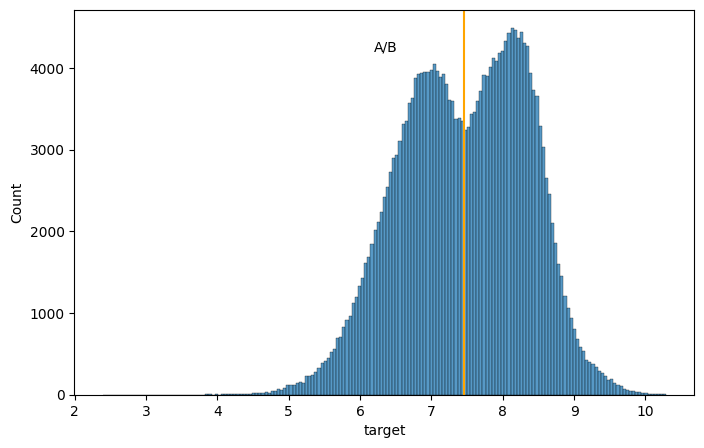

In [5]:
# target의 히스토그램 출력 및 구분선 출력 
plt.figure(figsize=(8, 5))
sns.histplot(data=df_train, x='target')
plt.axvline(7.45, c='orange')
plt.gca().annotate("A/B", (6.2, 4200))
plt.show()

In [7]:
df_train['targetA'] = df_train['target'] <= 7.45

## 단계 2

cat3 ~ 9 각각의 범주 중에서 빈도가 적은 범주를 target을 예측하는데 영향이 없는 방향으로 정리하려고 한다. 

아래 가이드에 맞추어 cat3 ~ 9 에 대한 전처리를 수행한다.

* cat3는 B→C 로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|
|-|-|-|
|83,634|147,361|9005|

* cat4는 A→B, D→B 로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|C|
|-|-|
|239,397|603|

* cat6는 D→A, E→B, G→C, H→B, I→A로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|C|
|-|-|-|
|234,203|5,145|652|

* cat7는 A→B, C→B, F→D, I→B로 치환한다.

Hint] 치환 후의 빈도 테이블

|B|D|E|G|
|-|-|-|-|
|4,606|19,784|214,027|1,583|

* cat8는 B→G, F→E로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|C|D|E|G|
|-|-|-|-|-|
|30,338|96,743|2,953|76,085|33,881|

* cat9는 C→H, D→B, E→L로 치환한다.

Hint] 치환 후의 빈도 테이블

|A|B|F|G|H|I|J|K|L|M|N|O|
|-|-|-|-|-|-|-|-|-|-|-|-|
|10,678|2,846|85,944|8,320|19,987|40,070|5,501|16,743|33,793|7,819|3,331|4,968|


In [16]:
a_list = [
    ('cat3', {'B': 'C'}),
    ('cat4', {'A': 'B', 'D': 'B'}),
    ('cat6', {'D': 'A', 'E': 'B', 'G': 'C', 'H': 'B', 'I': 'A'}),
    ('cat7', {'A': 'B', 'C': 'B', 'F': 'D', 'I': 'B'}),
    ('cat8', {'B': 'G', 'F': 'E'}),
    ('cat9', {'C': 'H', 'D': 'B', 'E': 'L'})
]
for i, j in a_list:
    df_train[i] = df_train[i].replace(j)

In [17]:
df_train.select_dtypes('object').apply(lambda x: x.value_counts()).unstack().dropna().to_frame()

0
cat0 A  225233.0
     B   14767.0
cat1 A  130134.0
     B  109866.0
cat2 A  221164.0
     B   18836.0
cat3 A   83634.0
     C  147361.0
     D    9005.0
cat4 B  239397.0
     C     603.0
cat5 A    3101.0
     B  119251.0
     C    9403.0
     D  108245.0
cat6 A  234203.0
     B    5145.0
     C     652.0
cat7 B    4606.0
     D   19784.0
     E  214027.0
     G    1583.0
cat8 A   30338.0
     C   96743.0
     D    2953.0
     E   76085.0
     G   33881.0
cat9 A   10678.0
     B    2846.0
     F   85944.0
     G    8320.0
     H   19987.0
     I   40070.0
     J    5501.0
     K   16743.0
     L   33793.0
     M    7819.0
     N    3331.0
     O    4968.0

In [18]:
df_basetable = df_train.copy()

# 문제1

범주형 변수의 조합의 특성을 파악하고자 한다. 다음 과정을 수행하라.

## 단계 1-1

basetable을 복사하여 prob1을 만들고 cat0 ~ 9 변수 순서대로 문자열 결합하여, 10자리 문자형 파생 변수(cat_c)를 생성하라.

In [24]:
cat_cols = ['cat{}'.format(i) for i in range(10)]
# 방법 1
df_basetable['cat_c'] = df_basetable[cat_cols].apply(lambda x: ''.join(list(x)), axis=1)
# 방법 2
#df_basetable[cat_cols].apply(lambda x: x.str.cat(), axis=1)
#df_basetable[cat_cols]

## 단계 1-2

50개 이상 행으로 이루지고, target에 대한 정규성을 부정할 수 없는 cat_c를 대상으로 cat_c_A와 cat_c_B를 구하라. 

정규성 검정은 Komogolov-Smironov 검정을 사용한다. (유의 수준: 5%)

- 행의 개수가 많은 순으로 cat_c 3개를 cat_c_A

- 행의 개수가 적은 순으로 cat_c 3개를 cat_c_B

* 행의 개수가 같을 경우에는 p-value가 높은 순으로 고른다.

Hint] scipy.stats.kstest

scipy.stats.norm.cdf


In [30]:
df_basetable.query("cat_c == 'AAAABBAECF'")['target'].values

array([7.40427, 6.95979, 6.93773, ..., 8.01333, 7.5208 , 6.45829])

In [31]:
from scipy.stats import kstest
from scipy.stats import norm

val = df_basetable.query("cat_c == 'AAAABBAECF'")['target']

kstest((val - val.mean()) / val.std(), norm.cdf)

KstestResult(statistic=0.06085563823469553, pvalue=2.165306258680074e-21)

In [34]:
from scipy.stats import zscore
kstest(zscore(val, ddof=1), norm.cdf)

KstestResult(statistic=0.06085563823469553, pvalue=2.165306258680074e-21)

In [38]:
import functools
kstest(val, functools.partial(norm.cdf, loc=val.mean(), scale=val.std()))

KstestResult(statistic=0.06085563823469553, pvalue=2.165306258680074e-21)

In [53]:
df_kstest = df_basetable.groupby('cat_c').filter(lambda x: len(x) >= 50)\
        .groupby('cat_c')\
        .apply(lambda x: pd.Series(kstest(zscore(x['target'], ddof=1), norm.cdf), index=['stat', 'pvalue']))\
        .join(df_basetable['cat_c'].value_counts().rename('cnt'))
df_kstest

,stat,pvalue,cnt
cat_c,,,
AAAABBADAF,0.093664,0.548731,69
AAAABBADCF,0.075332,0.100458,259
AAAABBADCI,0.084878,0.705019,65
AAAABBADEF,0.093602,0.586496,65
AAAABBAEAA,0.051012,0.922963,110
...,...,...,...
BBACBDAECF,0.075426,0.611944,97
BBACBDAEEF,0.085839,0.583426,78
BBACBDAEEI,0.107658,0.490084,57


In [76]:
cat_c_ =[]
for k, v in df_basetable['cat_c'].value_counts().items():
    if v < 50:
        break
    result = kstest(zscore(df_basetable.loc[df_basetable['cat_c'] == k, 'target'], ddof=1), norm.cdf)
    cat_c_.append((k, result, v))

df_kstest2 = pd.DataFrame({'cat_c': [i[0] for i in cat_c_],
                         'statistic': [i[1].statistic for i in cat_c_],
                         'pvalue': [i[1].pvalue for i in cat_c_],
                         'cnt': [i[2] for i in cat_c_]}).set_index('cat_c')

In [54]:
df_kstest = df_kstest.query('pvalue > 0.05').sort_values(['cnt', 'pvalue'], ascending=[False, True])

In [58]:
cat_c_a = df_kstest.iloc[:3].index.values
cat_c_b = df_kstest.iloc[-3:].index.values
cat_c_a, cat_c_b

(array(['ABACBBAEEI', 'AAAABBAEEI', 'AAACBDAEGI'], dtype=object),
 array(['ABADBDAEAL', 'BBAABDAEEF', 'ABBABBAECI'], dtype=object))

## 단계 1-3

bartlett 검정을 사용하여 cat_c_A에 해당하는 범주간에 target에 대한 등분산성을 조사했을 때 검정 통계량을 A라 한다. 

그리고 bartlett 검정을 사용하여 cat_c_B에 해당하는 범주간에 target에 대한 등분산성을 조사했을 때 검정 통계량을 B라고 한다. 


Hint] scipy.stats.bartlett

In [66]:
from scipy.stats import bartlett

result_A = bartlett(*df_basetable.loc[
            df_basetable['cat_c'].isin(cat_c_a)
        ].groupby('cat_c')['target'].agg(list).tolist())

A = result_A.statistic

result_B = bartlett(*df_basetable.loc[
            df_basetable['cat_c'].isin(cat_c_b)
        ].groupby('cat_c')['target'].agg(list).tolist())
B = result_B.statistic
A, result_A, B, result_B

(9.478560380242815,
 BartlettResult(statistic=9.478560380242815, pvalue=0.00874493861372744),
 0.4140582984181041,
 BartlettResult(statistic=0.4140582984181041, pvalue=0.8129959514532286))

## 단계 1-4

등분산성을 부정할 수 없는 경우는 경우는 단 하나 있다.

이 경우에 해당하는 행들을 대상으로 해당 범주 3개에 대해 분산분석(ANOVA)를 수행하고 p-value를 C라고 한다. 

Hint] scipy.stats.f_oneway



In [68]:
from scipy.stats import f_oneway
result = f_oneway(*df_basetable.loc[
            df_basetable['cat_c'].isin(cat_c_b)
        ].groupby('cat_c')['target'].agg(list).tolist()
)
C = result.pvalue

In [69]:
A + B + C

10.739784127341927

A + B + C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 표시하라.

**10.740**

# 문제 2

연속형 변수 cont0 ~ 13 중에서, 서로 피어슨 상관도(Pearson correlation)가 높은 변수들 찾고, 

이들을 PCA를 통한 차원 축소를 하여 성능 향상이 있는지 확인하고자 한다.

## 단계 2-1

basetable 에서 인덱스와 컬럼 모두 cont0 ~ 13이고, 

인덱스와 컬럼에 해당하는 변수 간에 피어슨 상관도(Pearson correlation)를 값으로 하는 대각 대칭형인 데이터프레임을 corr을 만든다.

## 단계 2-2

계층적 군집화를 활용하여 다음 개념도와 같이 연관성이 높은 변수 군집을 찾아 보고자 한다. 

초기에는 cont0~13 변수 각각을 하나의 군집으로 배정한 상태에서 시작하여, 

군집 간 결합 조건으로 두 군집에 포함된 변수간의 피어슨 상관도 절대값의 평균이 0.5이상 일 때, 

해당 수치가 높은 것을 우선으로 군집들을 결합한다. 군집의 크기가 가장 큰 변수들을 구하라.

Hint] sklearn.cluster.AgglomerativeClustering를 권장한다.


-	cont0 ~ 13간의 거리는 [단계 2-1] corr을 이용하여 군집 결합 조건을 고려하여 구한다. 

    (두 변수간에 피어슨 상관도의 절대값이 높을 수록 거리는 가깝다.)


## 단계 2-3

basetable에서 cat0 ~ 9을 각 변수의 첫 번째 범주(알파벳 순)를 제외하고 원핫 인코딩(One-hot encoding)하여 prob2를 만든다.

## 단계 2-4

prob2에서 80%는 학습용 prob2_train으로 20%는 테스트용 prob2_test으로 분리한다.


요건: sklearn.model_selection.train_test_split (random_state=123)을 사용한다.

## 단계 2-5

prob2_train으로 [단계 2-2]에서 도출된 변수들로 PCA 모델을 만들고 

분산 설명력이 높은 순으로 누적 분산 설명률이 0.8을 넘기는 최소의 컴포넌트를 prob2_train에 추가 한다. 

동일한 PCA 모델로 prob2_test를 변환하여 같은 수의 컴포넌트를 prob2_test에 추가 한다.

요건: sklearn.decomposition.PCA (입력의 순서는 cont 뒤의 번호가 낮은 것에서 높은 것 순으로 한다, random_state=123)


## 단계 2-6

prob2_train에서 target을 선형회귀모델로 학습하고 prob2_test를 다음 성능 지표로 평가한 값을 A라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
Hint] 학습데이터의 형태는 (192,000, 43) 이다. 

요건: sklearn.linear_model.LinearRegression

## 단계 2-7

prob2_train에서 cont0 ~ 13 중에서 PCA에서 사용했던 변수를 제외하고 

단계 2-5에서 추가한 PCA 컴포넌트를 포함하여 target로 선형회귀모델을 학습한다. 

prob2_test로 동일한 지표로 대한 성능 평가한 값을 B라 한다.


입력변수: cont0 ~ 13중 PCA에 사용한 것을 제외한 나머지 변수, 

PCA를 통한 파생 변수를 분산 설명력이 높은 순으로, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명, 범주명 알파벳 순서)

대상변수: target

성능지표:
 $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
요건: sklearn.linear_model.LinearRegression


A-B 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 구하라.
ex) 123.456

# 문제3

전처리 단계에서 target이 두 개의 정규 분포의 혼합한 형태 보이고 있음 확인했고, 

target을 7.45 경계값을 기준으로 A와 B범주로 나누었다. 

Gaussian Mixture라는 모델을 사용하여 두 개 정규 분포의 매개 변수를 측정했고, target의 분포를 시각화했다. 

아래 시각화 그래프에서 A, B가 혼재하여 A 또는 B라고 확신할 수는 없는 구간이 존재한다. 

확률을 기반으로, A 또는 B라고 확신할 수 있는 관측치만을 가지고 A / B를 분류 모델을 만들고자 한다. 다음 단계들을 수행하라.

## 단계 3-1

A 범주의 평균은 6.769 표준편차는 0.616이고 범주 B일 때 평균은 8.123 표준편차는 0.527이다. 

측정한 값을 범주A, B의 모집단의 target의 평균과 표준편차라고 가정한다. 

두 개의 정규 분포를 이용하여, 귀무가설이 ‘target은 A 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_A)를 만들다. 

반대로, 귀무가설이 ‘target은 B 범주에 해당한다’일 때 p-value를 구하여 파생변수(prob_B)를 만든다.

basetable에 두 개의 파생 변수 prob_A, prob_B를 추가하여 prob3 데이터프레임을 만든다.

Hint] scipy.stats.norm

## 단계 3-2

prob3 중에서 target이 A 또는 B라고 신뢰할 수 있는 행들만을 골라내고자 한다.

prob_B가 0.01 이거나, prob_A가 0.01 미만인 것만 남긴다. (즉, 위 그림에서 회색 영역에 해당하는 부분은 제외)

Hint] 행의 개수는 124,600가 된다.

## 단계 3-3

prob3에 cat0 ~ 9를 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 한다. 

Hint] sklearn.preprocessing.OneHotEncoder

## 단계 3-4

prob3를 학습용 80%, 그 외 20%는 테스트용으로 나누어 prob3_train, prob3_test로 한다.

요건] sklearn.model_selection.train_test_split, random_state=123

## 단계 3-5

prob3_train으로 target_A를 예측하는 xgboost 분류 모델을 다음과 같은 설정으로 prob3_train를 사용하여 학습한다. 

prob3_test으로 다음 성능지표로 평가한 값을 C 라고 한다.

입력변수: cont0 ~ 13, cat0 ~ 9까지 원핫-인코딩 파생 변수 (변수명, 범주순으로 알파벳 순서)

대상변수: targetA

성능지표: $Accuracy(Y, \hat(Y))=\frac{TP+TN}{TP+FP+TN+FN}$

요건] xgboost.XGBClassifier 하이퍼 파라미터(Hyper-Parameter, 초매개변수) 설정: 

|항목|값|
|----|--|
|트리의 최대 깊이|2|
|L1 규제|0.1|
|L2 규제|0.1|
|트리 당 컬럼 샘플링 비율|0.25|
|트리의 수|500|
|random_state|123|

Hint] sklearn.metrics.accuracy_score


C 를 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하라.

ex) 3.142

# 문제 4
 
위 차트는 cont0 의 히스토그램과 cont0를 300개의 분위 구간으로 나누어 x값은 분위 구간의 중간값, 

y값은 분위 구간에서 target의 평균을 산포도 그래프로 동시에 출력했다. 

좌측 y축은 히스토그램의 빈도수이고, 우측 y축은 target의 평균이다. 

히스토그램에서 동일한 봉우리 구간 내에서 cont0와 target간에 선형적 관계가 있음이 확인되었다. 

이 점을 이용하여 파생 변수를 만들어서 회귀모델을 만들어 간다.

## 단계 4-1

basetable에서 cat0 ~ 9을 첫 번째 범주(알파벳 순)는 제외하고 원핫 인코딩(One-Hot Encoding)하여 prob4데이터셋을 만든다.

## 단계 4-2

prob4의 80%를 prob4_train으로 20% prob4_test로 나눈다.

요건] sklearn.model_selection.train_test_split, random_state=123

## 단계 4-3

prob4_train에서 cont0를 100개의 우측이 닫힌 (ex. i번째 분위수 < cont0 ≤ i+1 번째 분위수) 분위 구간으로 나누고 

각각의 분위 구간에서 target의 평균을 구해 파생 변수 cont0_q를 만든다. 

prob4_test에는 prob4_train을 나누었던 구간과 평균으로 cont0_q를 만든다. 

이 때, prob4_test의 cont0값이 train의 첫 번째 구간보다 작다면, 첫 번째 구간으로 간주하고, 

마지막 구간보가 크다면, 마지막 구간으로 간주한다.

Hint 1] pandas.Series.quantile, pandas.cut 활용을 권장한다.

Hint 2] 두 번째 분위 구간은 0.0111 < cont0 <= 0.0176이고 target의 평균은 7.672 (셋째 자리까지 반올림)

Hint 3] cont0_q의 평균은 7.46, 표준 편차는 0.10 (소수점 둘째 자리까지 반올림)

## 단계 4-4

나머지 변수 cont1~13에 대해서도 해당 작업을 진행한다. 

생성한 파생 변수명은 원래의 변수명에 _q를 결합한다. (ex. cont1 -> cont1_q)

## 단계 4-5

prob4_train에서 target을 대상으로 선형회귀모델을 학습하고, 

prob4_test를 다음 지표로 성능 평가한 값을 D라고 한다. 

선형회귀 모델은 아래와 같은 손실함수로 학습을 한다.

$||Xw - y||^2_2 + \alpha||w||^2_2, \alpha = 0.1$

Hint] sklearn.linear_regression.Ridge 또는 Lasso 중 요건에 맞는 것을 사용한다. 

입력 변수: cont0_q ~ cont13_q, cat0 ~ 9까지 원핫-인코딩 후 나온 파생 변수 (변수명 다음 범주명으로 알파벳 순서이다)

대상 변수: target

성능 지표: $MSE(Y, \hat{Y}) = \frac{1}{n}\sum^{n}_{i=1}(y_i-\hat{y_i})^2\$
 
D를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하라.
ex) 123.45


# 문제 5


XGBoost 분류 모델의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색한다.

## 단계 5-1

basetable에 cat0 ~ 9 제외하는 범주 없이 원핫 인코딩(One-Hot Encoding) 하여 prob5를 만든다.

요건] sklearn.preprocessing.OneHotEncoder


## 단계 5-2

prob5를 80%는 학습용 prob5_train으로, 20%는 테스트용 prob5_test로 나눈다.

요건] sklearn.model_selection.train_test_split, random_state=123


## 단계 5-3

다음 회귀 분석 모델을 아래 3개의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 사용하여 

prob5_train으로 target를 학습시킨다.

prob5_test으로 테스트했을 때 , 최적의 성능을 낸 하이퍼 파라미터 셋의 번호를 A, 성능지표를 B라고 한다.

입력 변수] cont0~13, cat0 ~ 9을 원핫 인코딩하여 나온 파생 변수(변수명, 범주명 알파벳순)


대상 변수] target


성능 지표]
 
|No|하이퍼 파라미터(Hyper-parameter, 초매개변수)|
|--|--------------------------------------------|
|1|colsample_bytree=0.25, n_estimators=300|
|2|colsample_bytree=0.5, n_estimators=300|
|3|colsample_bytree=0.25, n_estimators=500|

요건] xgboost.XGBRegressor, max_depth=2, random_state=123 은 공통으로 설정한다.

A + B 를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.
